# Mount Drive and import basic libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Resize images

The images from the dataset do not have the same size, so the first step is to fix a height and width and transform all the images to the same size.

The bigger the image size the best reolution but also it will require bigger runtimes to process images and train model.

Original image  (480, 640, 3)


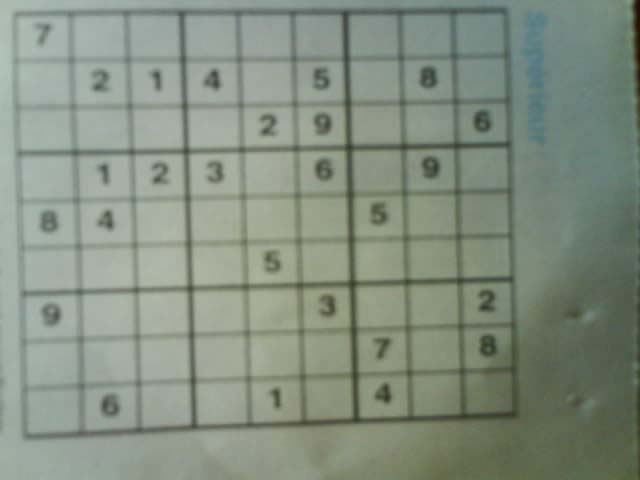

Resized image  (400, 400, 3)


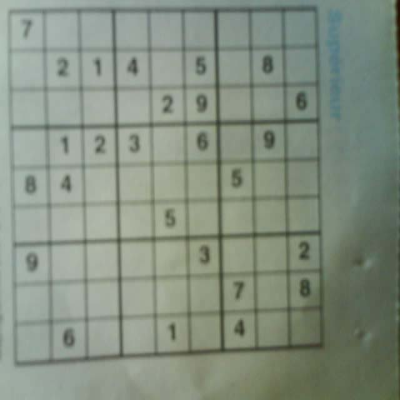

In [3]:
train_path = "/content/drive/MyDrive/sudoku_dataset/v2_train/"

# Read image
image = cv2.imread(train_path+os.listdir(train_path)[8])

# Resize image
height, width = 400, 400
resized_image = cv2.resize(image,(height,width))

# Show results
print("Original image ", image.shape)
cv2_imshow(image)
print("Resized image ", resized_image.shape)
cv2_imshow(resized_image)

We can appretiate that the resized image still has enough resolution to recognize the numbers easily.

Now we can resize all the images from the dataset:

In [4]:
train_path = "/content/drive/MyDrive/sudoku_dataset/v2_train/"
test_path = "/content/drive/MyDrive/sudoku_dataset/v2_test/"

# Fix the dimensions of the images
height, width = 400, 400

train_path_resized = "/content/drive/MyDrive/sudoku_dataset/v2_train_resized_"+str(height)+"_"+str(width)+"/"
test_path_resized = "/content/drive/MyDrive/sudoku_dataset/v2_test_resized_"+str(height)+"_"+str(width)+"/"

# Check if the destination folders exist. If not, they are created
os.mkdir(train_path_resized) if not os.path.isdir(train_path_resized) else None
os.mkdir(test_path_resized) if not os.path.isdir(test_path_resized) else None

for file in os.listdir(train_path):
  if file.endswith(".jpg"):
    image = cv2.imread(train_path+file)                 # Read
    resized_image = cv2.resize(image,(height,width))    # Resize
    cv2.imwrite(train_path_resized+file, resized_image) # Save

for file in os.listdir(test_path):
  if file.endswith(".jpg"):
    image = cv2.imread(test_path+file)                  # Read
    resized_image = cv2.resize(image,(height,width))    # Resize
    cv2.imwrite(test_path_resized+file, resized_image)  # Save

# Square Recognition and Perspective Transformation

The objetive in this section is to get and square image with only the sudoku grid inside.

*Steps:*

1. Detect the main sudoku square.
2. Crop the image to that square and use perspective transformation to get an square image.

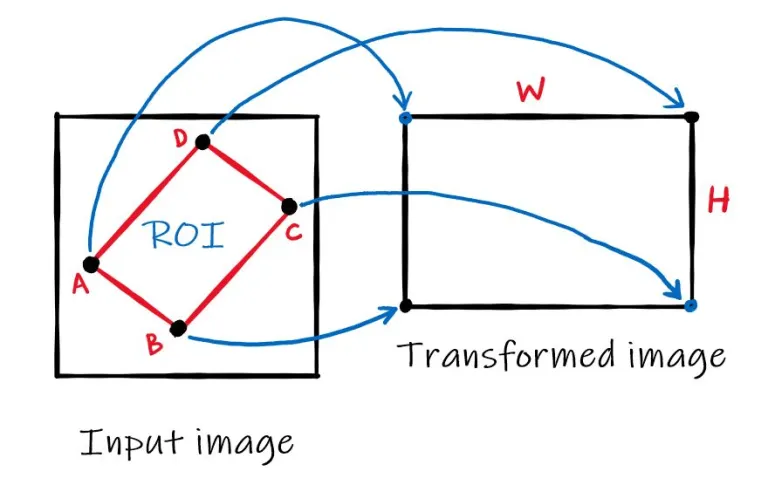

## 1 - Detect the sudoku square

In [4]:
import imutils

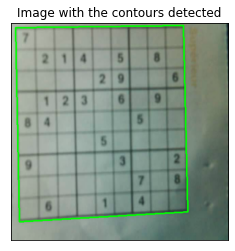

In [6]:
img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

ret,thresh = cv2.threshold(img,127,255,0)
thresh = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
thresh = cv2.bitwise_not(thresh)

contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

for contour in contours:
  # approximate the contour
  perimeter = cv2.arcLength(contour, True)
  approx = cv2.approxPolyDP(contour, 0.1 * perimeter, True)

  # if our approximated contour has four points, then we can
  # assume we have found the outline of the puzzle
  if len(approx) == 4:
    sudokuCnt = approx
    break

# if the puzzle contour is empty then our script could not find
# the outline of the Sudoku puzzle so raise an error

if sudokuCnt is None:
  raise Exception(("Could not find Sudoku puzzle outline. "
    "Try debugging your thresholding and contour steps."))

output = resized_image.copy()
cv2.drawContours(output, [sudokuCnt], -1, (0, 255, 0), 2)

plt.imshow(output)
plt.title("Image with the contours detected")
plt.xticks([])
plt.yticks([])
plt.show();

## 2 - Image crop and perspective transformation

Once we have the coordinates of the sudoku square grid we will use the openCV functions to crop and transform the part sudoku section of the image into a square image

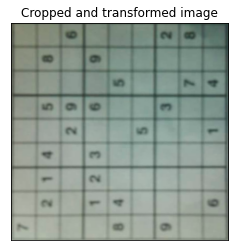

In [7]:
M = cv2.getPerspectiveTransform(sudokuCnt.astype(np.float32),
                                np.float32([[0,0],[0,height-1],[width-1,height-1],[width-1,0]]))

warped_image = cv2.warpPerspective(resized_image,M,(height, width),flags=cv2.INTER_LINEAR)

plt.imshow(warped_image)
plt.title('Cropped and transformed image')
plt.xticks([])
plt.yticks([]);

In this case the resulting warped image is return rotated. This is because the order of the points in the **sudokuCnt** array is not always the same when analyzing all the pictures. 
Because of that I have made the function **sort4points**, it returns the points in the correct order so the resulting image is not rotated.

In [8]:
def sort4points(points):
  """ 
  This function sorts the 4 square coordinates
  in order to make the persperctive transform correctly
  and get the sudoku in the straight position and not rotated.

  The points array needs to have shape (4,2) 
  with the coordinates in the order X, Y.
  
  We can easily distinguish points 1 and 3 because:
    - 1st point is the one with both X and Y low coordinates.
    - 3rd point is the one with both X and Y high coordinates.
  
  2nd and 4th points both have one high and one low coord,
  so then we have to compare their X coordinate to know
  which is which.

  # https://theailearner.com/tag/cv2-getperspectivetransform/
  """

  points_sum = [np.sum(p) for p in points]

  sorted_points_index = [x for _,x in sorted(zip(points_sum, np.arange(4)))]
  sorted_points_index

  point1 = points[sorted_points_index[0]]
  point3 = points[sorted_points_index[-1]]

  points_24 = points[sorted_points_index[1:3]]
  if points_24[0,0] < points_24[1,0]:
    point2, point4 = points_24[0], points_24[1]
  else:
    point2, point4 = points_24[1], points_24[0]
  
  return np.float32([point1, point2, point3, point4])

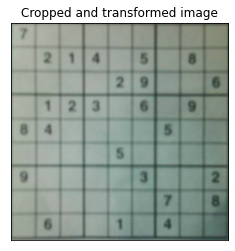

In [9]:
M = cv2.getPerspectiveTransform(sort4points(sudokuCnt[:,0,:]),
                                np.float32([[0,0],[0,height-1],[width-1,height-1],[width-1,0]]))

warped_image = cv2.warpPerspective(resized_image,M,(height, width),flags=cv2.INTER_LINEAR)


plt.imshow(warped_image)
plt.title('Cropped and transformed image')
plt.xticks([])
plt.yticks([]);

Now we can see that the resulting image is not rotated

## Making both steps together

In [10]:
def get_sudoku_image(image,debug=0,image_name=""):
  """
  Extracts the 4 main contours of an image.

  Then, crops the image and applies perespective transformation
  in order to get a squared image of just the sudoku grid.

  * Debug allows to show both images (before and after cropping and transformation)
  * image_name will be shown in the title of the images.
  """

  height, width,_ = image.shape
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  ret,thresh = cv2.threshold(img,127,255,0)
  thresh = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
  thresh = cv2.bitwise_not(thresh)

  contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(contours)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)

  sudokuCnt = None

  for contour in contours:
    # approximate the contour
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    # if our approximated contour has four points, then we can
    # assume we have found the outline of the puzzle
    if len(approx) == 4:
      sudokuCnt = approx
      break

  # if the puzzle contour is empty then our script could not find
  # the outline of the Sudoku puzzle so raise an error

  if sudokuCnt is None:
    raise Exception(("Could not find Sudoku puzzle outline. "
      "Try debugging your thresholding and contour steps."))

  if debug:

    output = image.copy()
    cv2.drawContours(output, [sudokuCnt], -1, (0, 255, 0), 2)

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(output)
    axs[0].set_title('Image no. '+image_name)

  # Square crop and perspective transform
  M = cv2.getPerspectiveTransform(sort4points(approx[:,0,:]),
                                np.float32([[0,0],[0,height-1],[width-1,height-1],[width-1,0]]))
  warped_image = cv2.warpPerspective(image,M,(height, width),flags=cv2.INTER_LINEAR)

  if debug:
    axs[1].imshow(warped_image)
    axs[1].set_title('Warped image')

  return warped_image

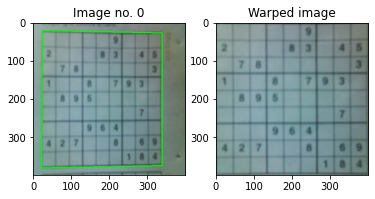

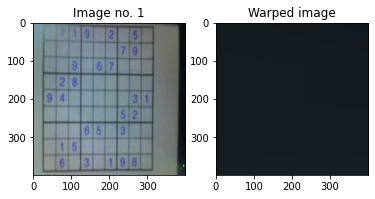

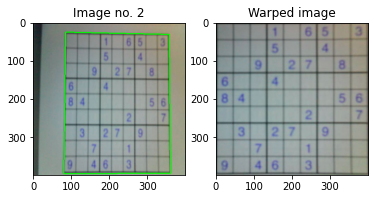

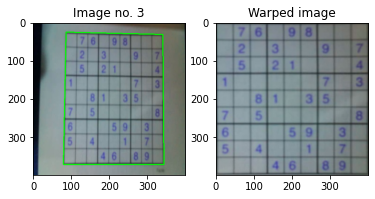

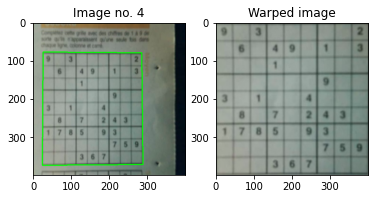

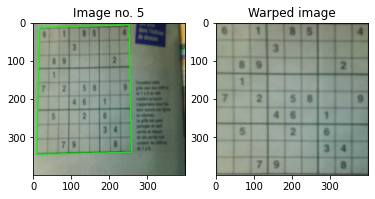

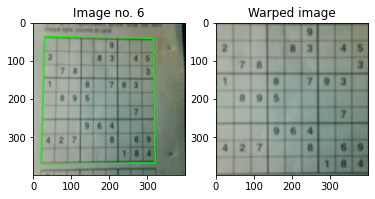

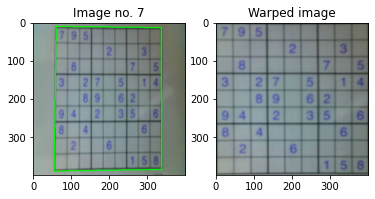

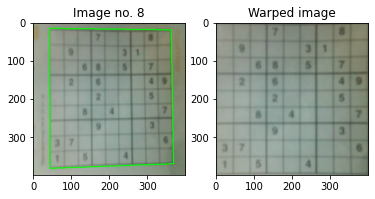

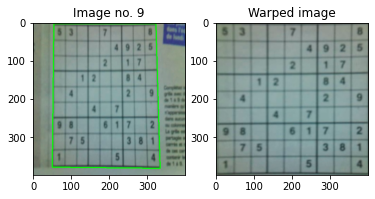

In [15]:
# Let's look at some exaples

train_path_resized = "/content/drive/MyDrive/sudoku_dataset/v2_train_resized_"+str(height)+"_"+str(width)+"/"

for i in range(10):
  image = cv2.imread(train_path_resized+os.listdir(train_path_resized)[i])
  get_sudoku_image(image,1,str(i))

**Warning!** This algorithm to obtain the sudoku image cropped is not perfect. In the image no. 1 we can see that in some cases **openCV** does not recognize well the sudoku square grid.

This issue requires further research and experimenting with the contour detecting tools, maybe adjusting the parameters of the adaptative threshold it can be solved.

# Split the image

Once we have a square image of the sudoku we can split the image in 81 square parts to obtain a single image for each sudoku cell.

In [16]:
from tensorflow.keras.preprocessing import image
from skimage.segmentation import clear_border

def split_and_treat_image(sudoku_image, debug=0):
  """ 
  This function split the square sudoku_image into 81 square parts.

  Each of each part is preprocessed in order to have a clearer
  image of the number in the cell.

  It returns a numpy array with the 81 images
  Shape: (9,9,pixels_x, pixels_y).

  * debug: Shows the 81 cell images in a 9x9 subplot.
  """

  height, width,_ = sudoku_image.shape

  # Calculates the size of the cell images
  pixels_x, pixels_y = np.rint(height/9).astype(int), np.rint(width/9).astype(int)
  cells_array = np.zeros((9,9,pixels_x,pixels_y))

  for n_row, x in enumerate(range(0,height,pixels_x)[:-1]):
    for n_col, y in enumerate(range(0,width,pixels_y)[:-1]):

      # Takes the cell image from the sudoku image
      cell_image = sudoku_image[pixels_x*n_row:pixels_x*(n_row+1), pixels_x*n_col:pixels_x*(n_col+1)].astype("uint8")
      # Apply preprocessing techniques
      cell_image = cv2.cvtColor(cell_image, cv2.COLOR_BGR2GRAY)
      thresh = cv2.threshold(cell_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
      thresh = clear_border(thresh)

      # Find the contours
      contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      contours = imutils.grab_contours(contours)
      # If no contours were found, then this is an empty cell
      if len(contours) == 0:
        cells_array[n_row, n_col,:,:] = thresh
        continue

      # otherwise, find the largest contour in the cell and create a
      # mask for the contour
      c = max(contours, key=cv2.contourArea)
      mask = np.zeros(thresh.shape, dtype="uint8")
      cv2.drawContours(mask, [c], -1, 255, -1)
      digit = cv2.bitwise_and(thresh, thresh, mask=mask)

      # Add the image to the array
      cells_array[n_row, n_col,:,:] = digit

  if debug:
    fig, axs = plt.subplots(9, 9, sharex=True, sharey=True, figsize=(10,10))
    for n_row in range(9):
      for n_col in range(9):
        axs[n_row,n_col].imshow(cells_array[n_row, n_col])
        axs[n_row,n_col].set_xticks([])
        axs[n_row,n_col].set_yticks([])
    plt.show()

  return cells_array

/content/drive/MyDrive/sudoku_dataset/v2_train_resized_400_400/image79.jpg


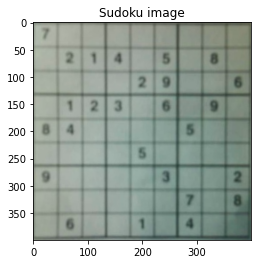

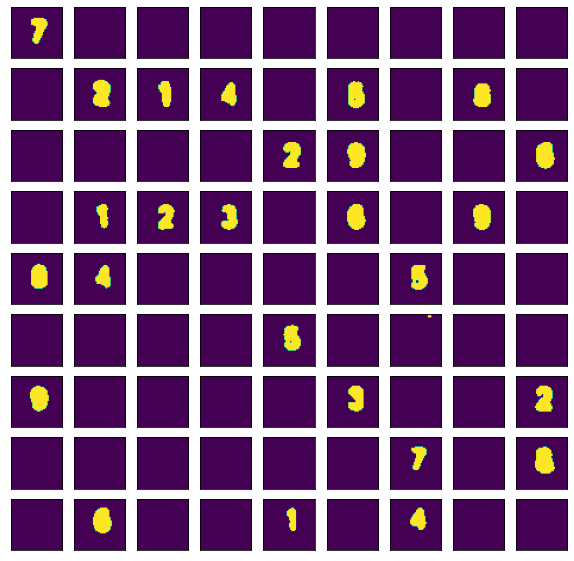

In [17]:
image_path = train_path_resized + os.listdir(train_path_resized)[10]
print(image_path)

image = cv2.imread(image_path)
image = get_sudoku_image(image)
plt.imshow(image)
plt.title("Sudoku image")
plt.show()
cells = split_and_treat_image(image,1)

# Generation of X and Y

Now we can generate our X and Y for training and testing.

In [18]:
train_path = "/content/drive/MyDrive/sudoku_dataset/v2_train/"
test_path = "/content/drive/MyDrive/sudoku_dataset/v2_test/"

train_path_resized = "/content/drive/MyDrive/sudoku_dataset/v2_train_resized_"+str(height)+"_"+str(width)+"/"
test_path_resized = "/content/drive/MyDrive/sudoku_dataset/v2_test_resized_"+str(height)+"_"+str(width)+"/"

save_files = False
destination_folder = "/content/drive/MyDrive/sudoku_dataset/single_images_"+str(height)+"_"+str(width)+"/"

first_file = True
for file in os.listdir(train_path_resized):
  if file.endswith(".jpg"):
    # Read the image
    sudoku_image = cv2.imread(train_path_resized+file)
    # Square recognition and perspective transformation
    sudoku_image = get_sudoku_image(sudoku_image)
    # Split sudoku image in 81 cell images
    cells = split_and_treat_image(sudoku_image)

    # Get sudoku numbers from .dat file
    sudoku_numbers = np.zeros((9,9),dtype=int)

    for row_index, row in enumerate(open(train_path + file[:-3] + "dat",'r')):
      if row_index >= 2:
        for col_index, i in enumerate(row.rstrip().split()):
          sudoku_numbers[row_index-2,col_index] = i

    # X and Y generation
    if first_file:
      X_train = np.expand_dims(np.array(cells), axis=0)
      Y_train = np.expand_dims(sudoku_numbers, axis=0)
      first_file = False
    else:
      X_train = np.concatenate((X_train,np.expand_dims(np.array(cells), axis=0)))
      Y_train = np.concatenate((Y_train, np.expand_dims(sudoku_numbers, axis=0)), axis=0)

first_file = True
for file in os.listdir(test_path_resized):
  if file.endswith(".jpg"):
    # Read the image
    sudoku_image = cv2.imread(test_path_resized+file)
    # Square recognition and perspective transformation
    sudoku_image = get_sudoku_image(sudoku_image)
    # Split sudoku image in 81 cell images
    cells = split_and_treat_image(sudoku_image)

    # Get sudoku numbers from .dat file
    sudoku_numbers = np.zeros((9,9),dtype=int)

    for row_index, row in enumerate(open(test_path + file[:-3] + "dat",'r')):
      if row_index >= 2:
        for col_index, i in enumerate(row.rstrip().split()):
          sudoku_numbers[row_index-2,col_index] = i

    # X and Y generation
    if first_file:
      X_test = np.expand_dims(np.array(cells), axis=0)
      Y_test = np.expand_dims(sudoku_numbers, axis=0)
      first_file = False
    else:
      X_test = np.concatenate((X_test,np.expand_dims(np.array(cells), axis=0)))
      Y_test = np.concatenate((Y_test, np.expand_dims(sudoku_numbers, axis=0)), axis=0)

if save_files:
  os.mkdir(destination_folder) if not os.path.isdir(destination_folder) else None
  np.save(destination_folder+"X_train.npy", X_train)
  np.save(destination_folder+"Y_train.npy", Y_train)
  np.save(destination_folder+"X_test.npy", X_test)
  np.save(destination_folder+"Y_test.npy", Y_test)

print("X_train shape: ", X_train.shape," Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape," Y_test shape: ", Y_test.shape)

X_train shape:  (160, 9, 9, 44, 44)  Y_train shape:  (160, 9, 9)
X_test shape:  (40, 9, 9, 44, 44)  Y_test shape:  (40, 9, 9)


[[9 0 3 0 0 0 0 0 2]
 [0 6 0 4 9 0 1 0 3]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 9 0 0]
 [3 0 1 0 0 4 0 0 0]
 [0 8 0 7 0 2 4 3 0]
 [1 7 8 5 0 9 3 0 0]
 [0 0 0 0 0 0 7 5 9]
 [0 0 0 3 6 7 0 0 0]]


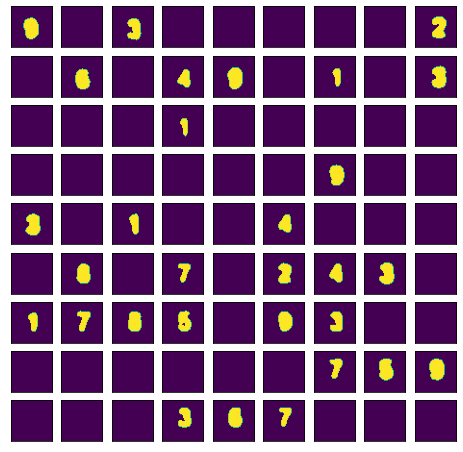

In [19]:
# Demonstration that X and Y are well synchronized
n = 4
cells_array = X_train[n]
print(Y_train[n])
fig, axs = plt.subplots(9, 9, sharex=True, sharey=True, figsize=(8,8))
for n_row in range(9):
  for n_col in range(9):
    axs[n_row,n_col].imshow(cells_array[n_row, n_col])
    axs[n_row,n_col].set_xticks([])
    axs[n_row,n_col].set_yticks([])
plt.show()

With these single cell images we can train a model to regonize the numbers in the sudoku.

# Whole pipeline in 1 cell

It can be more useful to reunite all the previous steps in a single cell, including resizing.

In [ ]:
import imutils
from tensorflow.keras.preprocessing import image
from skimage.segmentation import clear_border

In [ ]:
# Original paths
train_path = "/content/drive/MyDrive/sudoku_dataset/v2_train/"
test_path = "/content/drive/MyDrive/sudoku_dataset/v2_test/"

height, width = 400, 400

save_resized = True # Folders to save the resized images
train_path_resized = "/content/drive/MyDrive/sudoku_dataset/v2_train_resized_"+str(height)+"_"+str(width)+"/"
test_path_resized = "/content/drive/MyDrive/sudoku_dataset/v2_test_resized_"+str(height)+"_"+str(width)+"/"

save_X_Y = True # Folder to save the X and Y files
destination_folder = "/content/drive/MyDrive/sudoku_dataset/single_images_"+str(height)+"_"+str(width)+"/"

# TRAIN FILES
first_file = True
for file in os.listdir(train_path):
  if file.endswith(".jpg"):
    # Read image
    image = cv2.imread(train_path+file)
    
    # Resize image
    resized_image = cv2.resize(image,(height,width))
    if save_resized:
      os.mkdir(train_path_resized) if not os.path.isdir(train_path_resized) else None
      cv2.imwrite(train_path_resized+file, resized_image)

    # Square recognition and perspective transformation
    sudoku_image = get_sudoku_image(resized_image)
    # Split sudoku image in 81 cell images
    cells = split_and_treat_image(sudoku_image)
    
    # Get sudoku numbers from .dat file
    sudoku_numbers = np.zeros((9,9),dtype=int)

    for row_index, row in enumerate(open(train_path + file[:-3] + "dat",'r')):
      if row_index >= 2:
        for col_index, i in enumerate(row.rstrip().split()):
          sudoku_numbers[row_index-2,col_index] = i

    # Generation of X and Y
    if first_file:
      X_train = np.expand_dims(np.array(cells), axis=0)
      Y_train = np.expand_dims(sudoku_numbers, axis=0)
      first_file = False
    else:
      X_train = np.concatenate((X_train,np.expand_dims(np.array(cells), axis=0)))
      Y_train = np.concatenate((Y_train, np.expand_dims(sudoku_numbers, axis=0)), axis=0)

# TEST FILES
first_file = True
for file in os.listdir(test_path):
  if file.endswith(".jpg"):
    # Read image
    image = cv2.imread(test_path+file)
    
    # Resize image
    resized_image = cv2.resize(image,(height,width))
    if save_resized:
      os.mkdir(test_path_resized) if not os.path.isdir(test_path_resized) else None
      cv2.imwrite(test_path_resized+file, resized_image)

    # Square recognition and perspective transform
    sudoku_image = get_sudoku_image(resized_image)
    # Split sudoku image in 81 cell images
    cells = split_and_treat_image(sudoku_image)
    
    # Get sudoku numbers from .dat file
    sudoku_numbers = np.zeros((9,9),dtype=int)

    for row_index, row in enumerate(open(test_path + file[:-3] + "dat",'r')):
      if row_index >= 2:
        for col_index, i in enumerate(row.rstrip().split()):
          sudoku_numbers[row_index-2,col_index] = i

    # Generation of X and Y
    if first_file:
      X_test = np.expand_dims(np.array(cells), axis=0)
      Y_test = np.expand_dims(sudoku_numbers, axis=0)
      first_file = False
    else:
      X_test = np.concatenate((X_test,np.expand_dims(np.array(cells), axis=0)))
      Y_test = np.concatenate((Y_test, np.expand_dims(sudoku_numbers, axis=0)), axis=0)

# Saving the training and test files
if save_X_Y:
  os.mkdir(destination_folder) if not os.path.isdir(destination_folder) else None
  np.save(destination_folder+"X_train.npy", X_train)
  np.save(destination_folder+"Y_train.npy", Y_train)
  np.save(destination_folder+"X_test.npy", X_test)
  np.save(destination_folder+"Y_test.npy", Y_test)

print("X_train shape: ", X_train.shape," Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape," Y_test shape: ", Y_test.shape)

X_train shape:  (160, 9, 9, 44, 44)  Y_train shape:  (160, 9, 9)
X_test shape:  (40, 9, 9, 44, 44)  Y_test shape:  (40, 9, 9)


# Bibliography

**Dataset**: https://icosys.ch/sudoku-dataset

**Similar projects:** 
* https://pyimagesearch.com/2020/08/10/opencv-sudoku-solver-and-ocr/
* https://www.analyticsvidhya.com/blog/2021/05/solving-sudoku-from-image-using-deep-learning-with-python-code/

**OpenCV Contours:** 
* https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html
* https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html
* https://www.delftstack.com/howto/python/opencv-find-contours/

**Perspective transformation:** https://theailearner.com/tag/cv2-getperspectivetransform/

